# Interpret Models

You can use Azure Machine Learning to interpret a model by using an *explainer* that quantifies the amount of influence each feature contribues to the predicted label. There are many common explainers, each suitable for different kinds of modeling algorithm; but the basic approach to using them is the same.

## Install SDK packages

In addition to the latest version of the **azureml-sdk** and **azureml-widgets** packages, you'll need the **azureml-explain-model** package to run the code in this notebook. You'll also use the Azure ML Interpretability library (**azureml-interpret**). You can use this to interpret many typical kinds of model, even if they haven't been trained in an Azure ML experiment or registered in an Azure ML workspace.

Run the cell below to verify that these packages are installed. 

In [1]:
!pip show azureml-explain-model azureml-interpret

Name: azureml-explain-model
Version: 1.22.0
Summary: Machine Learning explain model package is used to interpret ML models
Home-page: https://docs.microsoft.com/python/api/overview/azure/ml/?view=azure-ml-py
Author: Microsoft Corp
Author-email: None
License: https://aka.ms/azureml-sdk-license
Location: /anaconda/envs/azureml_py36/lib/python3.6/site-packages
Requires: azureml-interpret
Required-by: 
---
Name: azureml-interpret
Version: 1.22.0
Summary: Machine Learning interpret package is used to interpret ML models
Home-page: https://docs.microsoft.com/python/api/overview/azure/ml/?view=azure-ml-py
Author: Microsoft Corp
Author-email: None
License: https://aka.ms/azureml-sdk-license
Location: /anaconda/envs/azureml_py36/lib/python3.6/site-packages
Requires: interpret-community, azureml-core
Required-by: azureml-train-automl-runtime, azureml-explain-model, azureml-contrib-interpret


## Explain a model

Let's start with a model that is trained outside of Azure Machine Learning - Run the cell below to train a decision tree classification model.

In [2]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# load the diabetes dataset
print("Loading Data...")
data = pd.read_csv('data/diabetes.csv')

# Separate features and labels
features = ['Pregnancies','PlasmaGlucose','DiastolicBloodPressure','TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','Age']
labels = ['not-diabetic', 'diabetic']
X, y = data[features].values, data['Diabetic'].values

# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Train a decision tree model
print('Training a decision tree model')
model = DecisionTreeClassifier().fit(X_train, y_train)

# calculate accuracy
y_hat = model.predict(X_test)
acc = np.average(y_hat == y_test)
print('Accuracy:', acc)

# calculate AUC
y_scores = model.predict_proba(X_test)
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))

print('Model trained.')

Loading Data...
Training a decision tree model
Accuracy: 0.89
AUC: 0.8758843723568336
Model trained.


The training process generated some model evaluation metrics based on a hold-back validation dataset, so you have an idea of how accurately it predicts; but how do the features in the data influence the prediction?

### Get an explainer for the model

Let's get a suitable explainer for the model from the Azure ML interpretability library you installed earlier. There are many kinds of explainer. In this example you'll use a *Tabular Explainer*, which is a "black box" explainer that can be used to explain many kinds of model by invoking an appropriate [SHAP](https://github.com/slundberg/shap) model explainer.

In [3]:
from interpret.ext.blackbox import TabularExplainer

# "features" and "classes" fields are optional
tab_explainer = TabularExplainer(model,
                             X_train, 
                             features=features, 
                             classes=labels)
print(tab_explainer, "ready!")

Could not import LIME, required for LIMEExplainer


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


TabularExplainer ready!


### Get *global* feature importance

The first thing to do is try to explain the model by evaluating the overall *feature importance* - in other words, quantifying the extent to which each feature influences the prediction based on the whole training dataset.

In [4]:
# you can use the training data or the test data here
global_tab_explanation = tab_explainer.explain_global(X_train)

# Get the top features by importance
global_tab_feature_importance = global_tab_explanation.get_feature_importance_dict()
for feature, importance in global_tab_feature_importance.items():
    print(feature,":", importance)

Pregnancies : 0.21907008286276114
Age : 0.1065194290941827
BMI : 0.09391099301496492
SerumInsulin : 0.06743554227479615
PlasmaGlucose : 0.04954357548816937
TricepsThickness : 0.021492117664078665
DiastolicBloodPressure : 0.01697597124677628
DiabetesPedigree : 0.01390017498632946


The feature importance is ranked, with the most important feature listed first.

### Get *local* feature importance

So you have an overall view, but what about explaining individual observations? Let's generate *local* explanations for individual predictions, quantifying the extent to which each feature influenced the decision to predict each of the possible label values. In this case, it's a binary model, so there are two possible labels (non-diabetic and diabetic); and you can quantify the influence of each feature for each of these label values for individual observations in a dataset. You'll just evaluate the first two cases in the test dataset.

In [5]:
# Get the observations we want to explain (the first two)
X_explain = X_test[0:2]

# Get predictions
predictions = model.predict(X_explain)

# Get local explanations
local_tab_explanation = tab_explainer.explain_local(X_explain)

# Get feature names and importance for each possible label
local_tab_features = local_tab_explanation.get_ranked_local_names()
local_tab_importance = local_tab_explanation.get_ranked_local_values()

for l in range(len(local_tab_features)):
    print('Support for', labels[l])
    label = local_tab_features[l]
    for o in range(len(label)):
        print("\tObservation", o + 1)
        feature_list = label[o]
        total_support = 0
        for f in range(len(feature_list)):
            print("\t\t", feature_list[f], ':', local_tab_importance[l][o][f])
            total_support += local_tab_importance[l][o][f]
        print("\t\t ----------\n\t\t Total:", total_support, "Prediction:", labels[predictions[o]])

Support for not-diabetic
	Observation 1
		 SerumInsulin : 0.36220009527769387
		 Age : 0.2449822010450017
		 TricepsThickness : 0.02177791054514406
		 BMI : 0.014131890289796938
		 DiabetesPedigree : 0.0012243737064597218
		 DiastolicBloodPressure : -0.016129478142479253
		 PlasmaGlucose : -0.0392341396878829
		 Pregnancies : -0.2555242816051632
		 ----------
		 Total: 0.3334285714285709 Prediction: not-diabetic
	Observation 2
		 BMI : 0.3550943394532993
		 Age : 0.018654514989073025
		 PlasmaGlucose : 0.017410347015797675
		 DiastolicBloodPressure : 0.013167929007840425
		 DiabetesPedigree : 0.005493200880138037
		 Pregnancies : -0.00880324485189666
		 TricepsThickness : -0.023934939064668658
		 SerumInsulin : -0.04365357600101238
		 ----------
		 Total: 0.3334285714285708 Prediction: not-diabetic
Support for diabetic
	Observation 1
		 Pregnancies : 0.255524281605163
		 PlasmaGlucose : 0.039234139687882974
		 DiastolicBloodPressure : 0.016129478142479295
		 DiabetesPedigree : -0.00122

## Adding explainability to a model training experiment

As you've seen, you can generate explanations for models trained outside of Azure Machine Learning; but when you use experiments to train and register models in your Azure Machine Learning workspace, you can generate model explanations and log them.

Run the code in the following cell to connect to your workspace.

> **Note**: If you haven't already established an authenticated session with your Azure subscription, you'll be prompted to authenticate by clicking a link, entering an authentication code, and signing into Azure.

In [6]:
import azureml.core
from azureml.core import Workspace

# Load the workspace from the saved config file
ws = Workspace.from_config()
print('Ready to use Azure ML {} to work with {}'.format(azureml.core.VERSION, ws.name))

Ready to use Azure ML 1.22.0 to work with azure_ds_challenge


### Train and explain a model using an experiment

OK, let's create an experiment and put the files it needs in a local folder - in this case we'll just use the same CSV file of diabetes data to train the model.

In [7]:
import os, shutil
from azureml.core import Experiment

# Create a folder for the experiment files
experiment_folder = 'diabetes_train_and_explain'
os.makedirs(experiment_folder, exist_ok=True)

# Copy the data file into the experiment folder
shutil.copy('data/diabetes.csv', os.path.join(experiment_folder, "diabetes.csv"))

'diabetes_train_and_explain/diabetes.csv'

Now we'll create a training script that looks similar to any other Azure ML training script except that is includes the following features:

- The same libraries to generate model explanations we used before are imported and used to generate a global explanation
- The **ExplanationClient** library is used to upload the explanation to the experiment output

In [8]:
%%writefile $experiment_folder/diabetes_training.py
# Import libraries
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Import Azure ML run library
from azureml.core.run import Run

# Import libraries for model explanation
from azureml.interpret import ExplanationClient
from interpret.ext.blackbox import TabularExplainer

# Get the experiment run context
run = Run.get_context()

# load the diabetes dataset
print("Loading Data...")
data = pd.read_csv('diabetes.csv')

features = ['Pregnancies','PlasmaGlucose','DiastolicBloodPressure','TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','Age']
labels = ['not-diabetic', 'diabetic']

# Separate features and labels
X, y = data[features].values, data['Diabetic'].values

# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Train a decision tree model
print('Training a decision tree model')
model = DecisionTreeClassifier().fit(X_train, y_train)

# calculate accuracy
y_hat = model.predict(X_test)
acc = np.average(y_hat == y_test)
run.log('Accuracy', np.float(acc))

# calculate AUC
y_scores = model.predict_proba(X_test)
auc = roc_auc_score(y_test,y_scores[:,1])
run.log('AUC', np.float(auc))

os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=model, filename='outputs/diabetes.pkl')

# Get explanation
explainer = TabularExplainer(model, X_train, features=features, classes=labels)
explanation = explainer.explain_global(X_test)

# Get an Explanation Client and upload the explanation
explain_client = ExplanationClient.from_run(run)
explain_client.upload_model_explanation(explanation, comment='Tabular Explanation')

# Complete the run
run.complete()

Writing diabetes_train_and_explain/diabetes_training.py


Now you can run the experiment. Note that the **azureml-interpret** library is included in the training environment so the script can create a **TabularExplainer** and use the **ExplainerClient** class.

In [9]:
from azureml.core import Experiment, ScriptRunConfig, Environment
from azureml.core.conda_dependencies import CondaDependencies
from azureml.widgets import RunDetails


# Create a Python environment for the experiment
explain_env = Environment("explain-env")

# Create a set of package dependencies (including the azureml-interpret package)
packages = CondaDependencies.create(conda_packages=['scikit-learn','pandas','pip'],
                                    pip_packages=['azureml-defaults','azureml-interpret'])
explain_env.python.conda_dependencies = packages

# Create a script config
script_config = ScriptRunConfig(source_directory=experiment_folder,
                      script='diabetes_training.py',
                      environment=explain_env) 

# submit the experiment
experiment_name = 'mslearn-diabetes-explain'
experiment = Experiment(workspace=ws, name=experiment_name)
run = experiment.submit(config=script_config)
RunDetails(run).show()
run.wait_for_completion()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

{'runId': 'mslearn-diabetes-explain_1616853351_6e72fbe1',
 'target': 'local',
 'status': 'Completed',
 'startTimeUtc': '2021-03-27T13:57:57.359143Z',
 'endTimeUtc': '2021-03-27T13:58:10.301861Z',
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': 'fbf5e936-fa4c-444d-b337-34c9eeebf6e6',
  'azureml.git.repository_uri': 'https://github.com/MicrosoftLearning/mslearn-dp100',
  'mlflow.source.git.repoURL': 'https://github.com/MicrosoftLearning/mslearn-dp100',
  'azureml.git.branch': 'main',
  'mlflow.source.git.branch': 'main',
  'azureml.git.commit': 'f239fd89deb74b8808e79f452dab1b737a3c3070',
  'mlflow.source.git.commit': 'f239fd89deb74b8808e79f452dab1b737a3c3070',
  'azureml.git.dirty': 'True'},
 'inputDatasets': [],
 'outputDatasets': [],
 'runDefinition': {'script': 'diabetes_training.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': [],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'local',
 

## Retrieve the feature importance values

With the experiment run completed, you can use the **ExplanationClient** class to retrieve the feature importance from the explanation registered for the run.

In [10]:
from azureml.interpret import ExplanationClient

# Get the feature explanations
client = ExplanationClient.from_run(run)
engineered_explanations = client.download_model_explanation()
feature_importances = engineered_explanations.get_feature_importance_dict()

# Overall feature importance
print('Feature\tImportance')
for key, value in feature_importances.items():
    print(key, '\t', value)

Feature	Importance
Pregnancies 	 0.2221107854950433
Age 	 0.10478143842605886
BMI 	 0.09687162183996328
SerumInsulin 	 0.06896564748205354
PlasmaGlucose 	 0.04942209554110363
TricepsThickness 	 0.022343052748640894
DiastolicBloodPressure 	 0.01741545696313669
DiabetesPedigree 	 0.016539713962714336


## View the model explanation in Azure Machine Learning studio

You can also click the **View run details** link in the Run Details widget to see the run in Azure Machine Learning studio, and view the **Explanations** tab. Then:

1. Select the explanation ID for your tabular explainer.
2. View the **Aggregate feature importance** chart, which shows the overall global feature importance.
3. View the **Individual feature importance** chart, which shows each data point from the test data.
4. Select an individual point to see the local feature importance for the individual prediction for the selected data point.


**More Information**: For more information about using explainers in Azure ML, see [the documentation](https://docs.microsoft.com/azure/machine-learning/how-to-machine-learning-interpretability). 

#### Extra Note:

#### Feature importance


Model explainers use statistical techniques to calculate feature importance. This enables you to quantify the relative influence each feature in the training dataset has on label prediction. Explainers work by evaluating a test data set of feature cases and the labels the model predicts for them.

##### Global feature importance

Global feature importance quantifies the relative importance of each feature in the test dataset as a whole. It provides a general comparison of the extent to which each feature in the dataset influences prediction.

For example, a binary classification model to predict loan default risk might be trained from features such as loan amount, income, marital status, and age to predict a label of 1 for loans that are likely to be repaid, and 0 for loans that have a significant risk of default (and therefore shouldn't be approved). An explainer might then use a sufficiently representative test dataset to produce the following global feature importance values:

    income: 0.98
    loan amount: 0.67
    age: 0.54
    marital status 0.32

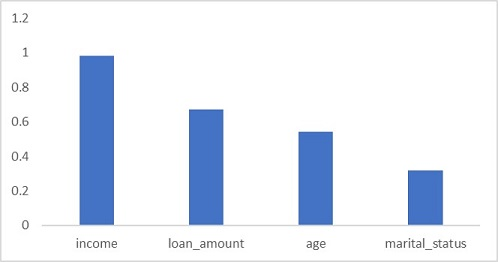

It's clear from these values, that in respect to the overall predictions generated by the model for the test dataset, income is the most important feature for predicting whether or not a borrower will default on a loan, followed by the loan amount, then age, and finally marital status.

##### Local feature importance

Local feature importance measures the influence of each feature value for a specific individual prediction.

For example, suppose Sam applies for a loan, which the machine learning model approves (by predicting that Sam won't default on the loan repayment). You could use an explainer to calculate the local feature importance for Sam's application to determine which factors influenced the prediction. You might get a result like this:

Feature 	Support for 0 	Support for 1
loan amount 	-0.9 	0.9
income 	-0.6 	0.6
age 	0.2 	-0.2
marital status 	-0.1 	0.1

Because this is a classification model, each feature gets a local importance value for each possible class, indicating the amount of support for that class based on the feature value. Since this is a binary classification model, there are only two possible classes (0 and 1). Each feature's support for one class results in correlatively negative level of support for the other.

##### Local feature importance chart

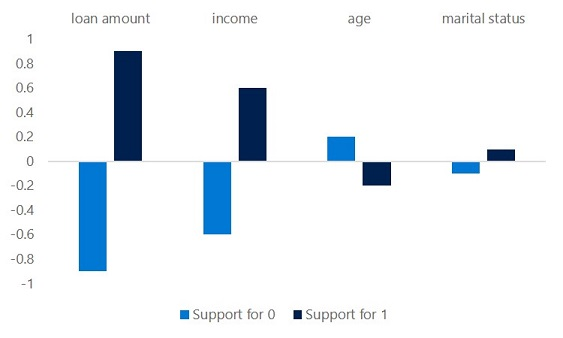

In Sam's case, the overall support for class 0 is -1.4, and the support for class 1 is correspondingly 1.4; so support for class 1 is higher than for class 0, and the loan is approved. The most important feature for a prediction of class 1 is loan amount, followed by income - these are the opposite order from their global feature importance values (which indicate that income is the most important factor for the data sample as a whole). There could be multiple reasons why local importance for an individual prediction varies from global importance for the overall dataset; for example, Sam might have a lower income than average, but the loan amount in this case might be unusually small.

For a multi-class classification model, a local importance values for each possible class is calculated for every feature, with the total across all classes always being 0. For example, a model might predict the species of a penguin based on features like its bill length, bill width, flipper length, and weight. Suppose there are three species of penguin, so the model predicts one of three class labels (0, 1, or 2). For an individual prediction, the flipper length feature might have local importance values of 0.5 for class 0, 0.3 for class 1, and -0.8 for class 2 - indicating that the flipper length moderately supports a prediction of class 0, slightly supports a prediction of class 1, and strongly supports a prediction that this particular penguin is not class 2.

For a regression model, there are no classes so the local importance values simply indicate the level of influence each feature has on the predicted scalar label.


#### Using explainers


You can use the Azure Machine Learning SDK to create explainers for models, even if they were not trained using an Azure Machine Learning experiment.

##### Creating an explainer

To interpret a local model, you must install the azureml-interpret package and use it to create an explainer. There are multiple types of explainer, including:

    MimicExplainer - An explainer that creates a global surrogate model that approximates your trained model and can be used to generate explanations. This explainable model must have the same kind of architecture as your trained model (for example, linear or tree-based).
    TabularExplainer - An explainer that acts as a wrapper around various SHAP explainer algorithms, automatically choosing the one that is most appropriate for your model architecture.
    PFIExplainer - a Permutation Feature Importance explainer that analyzes feature importance by shuffling feature values and measuring the impact on prediction performance.

The following code example shows how to create an instance of each of these explainer types for a hypothetical model named loan_model:

```
# MimicExplainer
from interpret.ext.blackbox import MimicExplainer
from interpret.ext.glassbox import DecisionTreeExplainableModel

mim_explainer = MimicExplainer(model=loan_model,
                             initialization_examples=X_testExplaining global feature importance

To retrieve global importance values for the features in your mode, you call the explain_global() method of your explainer to get a global explanation, and then use the get_feature_importance_dict() method to get a dictionary of the feature importance values. The following code example shows how to retrieve global feature importance:,
                             explainable_model = DecisionTreeExplainableModel,
                             features=['loan_amount','income','age','marital_status'], 
                             classes=['reject', 'approve'])
                             

# TabularExplainer
from interpret.ext.blackbox import TabularExplainer

tab_explainer = TabularExplainer(model=loan_model,
                             initialization_examples=X_test,
                             features=['loan_amount','income','age','marital_status'],
                             classes=['reject', 'approve'])


# PFIExplainer
from interpret.ext.blackbox import PFIExplainer

pfi_explainer = PFIExplainer(model = loan_model,
                             features=['loan_amount','income','age','marital_status'],
                             classes=['reject', 'approve'])
```

##### Explaining global feature importance

To retrieve global importance values for the features in your mode, you call the explain_global() method of your explainer to get a global explanation, and then use the get_feature_importance_dict() method to get a dictionary of the feature importance values. The following code example shows how to retrieve global feature importance:

```
# MimicExplainer
global_mim_explanation = mim_explainer.explain_global(X_train)
global_mim_feature_importance = global_mim_explanation.get_feature_importance_dict()


# TabularExplainer
global_tab_explanation = tab_explainer.explain_global(X_train)
global_tab_feature_importance = global_tab_explanation.get_feature_importance_dict()


# PFIExplainer
global_pfi_explanation = pfi_explainer.explain_global(X_train, y_train)
global_pfi_feature_importance = global_pfi_explanation.get_feature_importance_dict()
```

Note

The code is the same for MimicExplainer and TabularExplainer. The PFIExplainer requires the actual labels that correspond to the test features.

##### Explaining local feature importance

To retrieve local feature importance from a MimicExplainer or a TabularExplainer, you must call the explain_local() method of your explainer, specifying the subset of cases you want to explain. Then you can use the get_ranked_local_names() and get_ranked_local_values() methods to retrieve dictionaries of the feature names and importance values, ranked by importance. The following code example shows how to retrieve local feature importance:

```
# MimicExplainer
local_mim_explanation = mim_explainer.explain_local(X_test[0:5])
local_mim_features = local_mim_explanation.get_ranked_local_names()
local_mim_importance = local_mim_explanation.get_ranked_local_values()


# TabularExplainer
local_tab_explanation = tab_explainer.explain_local(X_test[0:5])
local_tab_features = local_tab_explanation.get_ranked_local_names()
local_tab_importance = local_tab_explanation.get_ranked_local_values()
```

Note

The code is the same for MimicExplainer and TabularExplainer. The PFIExplainer doesn't support local feature importance explanations.